# Welcome to Receptiviti!

If this is your first time using the Receptiviti API - check out our [Getting Started guide](https://github.com/Receptiviti/api_tutorials_demos/blob/main/tutorials/python/Getting%20Started.ipynb)

All our other [tutorials can be found here](https://dashboard.receptiviti.com/docs/tutorials)

SALLEE is Receptiviti's emotion and sentiment detection engine and is made available through the Receptiviti API. For more details on SALLEE, [check out our documentation here](https://dashboard.receptiviti.com/docs/frameworks-and-measures#sallee-about).

In this Jupyter Notebook, we will examine the emotional underpinnings of text gathered from a social media context i.e. Reddit. We will also find out how to batch a bulk request to the API i.e. send say 5 batches of 1000 texts to be scored by the Receptiviti API.

Play around with the code on this notebook, modify it to your liking and most importantly, have buckets of fun!

Let's begin with:

## Step 1 - Your API Keys
**Don't forget to add your API key and secret into the following cell**

In [9]:
API_KEY = ''
API_SECRET = ''
API_URL = 'https://api.receptiviti.com/v1/score'

## Step 2 - Install python libraries

If you are running this notebook within a Google Colab environment, follow the instructions [here](#Option-1---Google-Colab). Google Colab provides all the requisite python libraries you will need to execute this Jupyter Notebook. 

If you are running this notebook locally or on your own server setup, determine if your system uses Conda or Pip to manage python dependencies. If you prefer Conda, follow the instructions [here](#Option-2---Conda) to install the requisite python libraries. If you prefer Pip, follow the instructions [here](#Option-3---Pip).

***Remember*** that you will only need to use either Conda ***or*** Pip to set up your python environment locally - not both. 

### Option 1 - Google Colab

Uncomment the cell below and run

In [279]:
#!pip install convokit

### Option 2 - Conda
Uncomment the cell below and run

In [277]:
# import sys
# !conda install --yes --prefix {sys.prefix} requests pandas numpy matplotlib convokit

### Option 3 - Pip
Uncomment the cell below and run

In [278]:
# import sys
# !{sys.executable} -m pip install requests pandas numpy matplotlib convokit

## Step 3 - Explore the dataset

We use the Cornell Conversational Toolkit library to examine a small corpus of Reddit data. This toolkit provides convenient access to conversational datasets that are out-of-the-box. In this Jupyter Notebook, we will examine a small reddit corpus, sampled from 100 active subreddits. 

For further details on `convokit`, check out their:

- **[Github](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit)**
- **[Documentation](https://convokit.cornell.edu/documentation/)**

In [2]:
from convokit import Corpus, download
corpus = Corpus(filename=download("reddit-corpus-small"))
corpus.print_summary_stats()
df = corpus.get_utterances_dataframe()

Dataset already exists at /Users/varshas/.convokit/downloads/reddit-corpus-small
Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


### Step 3.1 - Filter the dataset for this tutorial

In this step, we will remove all text samples that have no usable text in them e.g. - they are empty or have been removed due to moderation or deleted for other reasons. 

Next, we will choose a set of 3 interesting subreddits to work with to facilitate a quick, but thorough tutorial. Here we choose - `r/canada`, `r/business` and `r/askscience`.

In [3]:
filtered_df = df[(df['text']!='') & (df['text']!='[removed]') & (df['text']!='[deleted]')]
print("Quick description of data")
grouping = filtered_df.groupby('meta.subreddit')['text'].describe().reset_index().sort_values(by='count', ascending=False)
display(grouping)
print("Let's choose 3 interesting but distinct subreddits")
subs = ['canada', 'business', 'askscience']
print("There are: \n{}".format(subs))
filtered_df = filtered_df[filtered_df['meta.subreddit'].isin(subs)]

Quick description of data


,meta.subreddit,count,unique,top,freq
74,pics,6722,6678,Yes,5
93,todayilearned,6645,6604,Yes,5
55,explainlikeimfive,6462,6426,Thanks!,5
98,worldnews,5200,5189,Source?,3
97,videos,5141,5111,Supposedly the extent to which that scene went...,4
...,...,...,...,...,...
89,techsupport,1528,1523,yes,3
67,motorcycles,1518,1512,##NEW BIKE SUPERTHREAD! - a thread for questio...,4
81,rupaulsdragrace,1398,1386,Sasha's was okay compared to Alyssa. SKDKKKLLSKK,5
30,OkCupid,1348,1340,Got a sexy new pair of jeans? Unsure if your b...,4


Let's choose 3 interesting but distinct subreddits
There are: 
['canada', 'business', 'askscience']


### Step 3.2 - Attach a request id
It's generally good practice not to rely on the order of results returned by the API to match the order in which text samples are sent to the API for scoring. Amongst several advantages of using a token like a request id to keep track of which row generated which score is the ability to be thread safe and use multiprocessing to score multiple batches of text at once. We will demonstrate how to use this feature in the Receptiviti API below.

Let's start by attaching a column called `request_id` to the dataframe. We will see how this becomes useful in [Step 5](#Step-5---Convert-into-a-table-format-and-Join-with-Original-data)

In [4]:
from uuid import uuid4
filtered_df['request_id'] = filtered_df.apply(lambda _: str(uuid4()), axis=1)
print("Number of text samples: {}".format(filtered_df.shape))
display(filtered_df.head())

Number of text samples: (9399, 15)


,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,request_id
id,,,,,,,,,,,,,,,
9e22yl,1536386234,The title says it all! Do you think his new pa...,RedarmRonny,None,9e22yl,2,None,1540093243,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9e22yl/what_do_you_think_of...,,3e26c5aa-dd38-49c0-8ba3-db9de9074187
9h1qla,1537328102,Aberfoyle is a small community outside of Guel...,ineedmoney17,None,9h1qla,96,None,1540143612,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9h1qla/can_rcanada_work_tog...,,73cf4613-8646-4a56-acfc-4e2117ba2a50
9hzbt5,1537619365,Even some countries that are significantly poo...,theusernameIhavepick,None,9hzbt5,1065,None,1540159386,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9hzbt5/why_does_canada_have...,,7340a9a1-30c5-4d14-9ac9-189120d56c67
9iwdc9,1537911518,You may not know about it (I barely ever see i...,expendablethoughts,None,9iwdc9,162,None,1540174815,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9iwdc9/extremely_low_unempl...,Québec,bf9c0e61-f661-4432-aeee-6c34bd43361d
e56wrws,1535767534,Says a US-owned RW rag with zero cred,kudatah,9bz9c7,9bz9c7,-19,e56wrws,1538541908,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9bz9c7/np_view_the_credibil...,,b4762c2d-1b3e-473e-a1d0-4e824721a2d8


## Step 4 - Completing a bulk request

Let's start by creating an API helper function to handle a bulk request.

In [5]:
import json
import requests

def get_payload_and_url(text, request_id):
    payload_url_tup = ({}, '')
    if len(text)<1:
        print("ERROR: 'text' should not be empty")
    if len(text)!=len(request_id):
        print("ERROR: 'text' and 'request_ids' should have the same length")
    if isinstance(text, str):
        payload_url_tup = ({
                    "content": text,
                    "request_id": request_id
                }, API_URL)
    if isinstance(text, list):
        payload_url_tup = ([{
                    "content": content,
                    "request_id": r_id
        } for content, r_id in zip(text, request_id)], API_URL + '/bulk')
    return payload_url_tup

def call_receptiviti_api(text, request_id):
    payload, url = get_payload_and_url(text, request_id)
    results = []
    if len(payload)>0:
        response = requests.post(url, data=json.dumps(payload), auth=(API_KEY, API_SECRET), headers = {'Content-Type': 'application/json'})
        if response.status_code==200:
            results = response.json()
    return results

# print out the results
print("Bulk Call to Receptiviti API")
print("Truncated output...")
bulk_result = call_receptiviti_api(filtered_df['text'].to_list(), filtered_df['request_id'].to_list())
print(json.dumps(bulk_result, indent=4)[0:1000])

Bulk Call to Receptiviti API
Truncated output...
{
    "plan_usage": {
        "word_limit": 250000,
        "words_used": 15114191,
        "words_remaining": 0,
        "percent_used": 6045.68,
        "start_date": "2021-02-03T00:00:00Z",
        "end_date": "2021-03-02T23:59:59Z"
    },
    "results": [
        {
            "response_id": "86b1128c-96c0-4f00-b6ac-84b70b1cf2fc",
            "request_id": "3e26c5aa-dd38-49c0-8ba3-db9de9074187",
            "language": "en",
            "version": "v1.0.0",
            "summary": {
                "word_count": 31,
                "words_per_sentence": 7.75,
                "sentence_count": 4,
                "six_plus_words": 0.2903225806451613,
                "capitals": 0.03424657534246575,
                "emojis": 0,
                "emoticons": 0,
                "hashtags": 0,
                "urls": 0
            },
            "dictionary_measures": {
                "achievement": 0.03225806451612903,
                "adj

## Step 5 - Convert into a table format and Join with Original data

The Receptiviti API outputs a JSON object containing scores. In the cell below, we convert this JSON object into a table format using Python library [pandas](http://pandas.pydata.org/). Once converted into a table format or a dataframe, as it is commonly known, it becomes easier to read and digest.

When it's time to do analysis with the scores, it's great to have the metadata from the original dataset also be present along with the scores. This allows us to examine score differences across different groups. E.g., here, we could look at SALLEE `curiosity` scores across various subreddits (column `meta.subreddit`).

Let's complete the join and look at some descriptive statistics across various `subreddits` and `speakers`.

In [6]:
from IPython.display import Markdown
import pandas as pd

def convert_scores_to_table(results):
    dictionary_measures = []
    if len(results)>0:
        for result in results['results']:
            if 'dictionary_measures' in result:
                # Pull out dictionary_measures
                measures = result['dictionary_measures']
                measures.update({'request_id': result['request_id']})
                dictionary_measures.append(measures)
    return pd.DataFrame(dictionary_measures)

bulk_dictionary_measures_df = convert_scores_to_table(bulk_result)
if len(bulk_dictionary_measures_df)>0:
    merged_dictionary_measures_df = bulk_dictionary_measures_df.merge(filtered_df, on='request_id')
    print("Dictionary measures merged with original dataset")
    display(merged_dictionary_measures_df.head())
else: 
    display(Markdown("### **Your plan does not appear to include the SALLEE package. If you are interested in adding the SALLEE Package to your plan, please [contact us](http://dashboard.receptiviti.com/contact).**<br/>"))
    display(Markdown("[Documentation on the SALLEE measures](https://dashboard.receptiviti.com/docs/frameworks-and-measures#sallee-about)<br/>[Our Pricing](https://www.receptiviti.com/pricing)"))


Dictionary measures merged with original dataset


,achievement,adjectives,admiration,adverbs,affective_processes,affiliation,all_punctuation,ambifeel,amusement,analytical_thinking,...,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text
0,0.032258,0.096774,0.082282,0.000000,0.064516,0.032258,0.129032,0.000000,0.0,0.281899,...,9e22yl,2,None,1540093243,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9e22yl/what_do_you_think_of...,
1,0.012500,0.050000,0.054645,0.031250,0.043750,0.062500,0.237500,0.000000,0.0,0.890286,...,9h1qla,96,None,1540143612,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9h1qla/can_rcanada_work_tog...,
2,0.000000,0.172414,0.000000,0.034483,0.068966,0.000000,0.137931,0.000000,0.0,0.317852,...,9hzbt5,1065,None,1540159386,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9hzbt5/why_does_canada_have...,
3,0.011416,0.038813,0.035086,0.061644,0.029680,0.006849,0.162100,0.004189,0.0,0.588620,...,9iwdc9,162,None,1540174815,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9iwdc9/extremely_low_unempl...,Québec
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.0,0.988679,...,9bz9c7,-19,e56wrws,1538541908,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",canada,False,/r/canada/comments/9bz9c7/np_view_the_credibil...,


## Step 6 - Examine SALLEE scores by subreddit

**This section will work if you see non-empty dictionary_measures and SALLEE measures [above](Step-5---Convert-into-a-table-format-and-Join-with-Original-data). Your plan might not include SALLEE as an output. If you are interested in adding SALLEE to your plan, please [contact us](http://dashboard.receptiviti.com/contact).**

In this section, we will examine positive, neutral and negative SALLEE scores i.e. emotions across the 3 subreddits [we chose earlier here](#Step-3.1---Filter-the-dataset-for-this-tutorial). This is not meant to be a statistical exmaintion of group differences, rather a visual that supports our intuition about the contents of the subreddits.

Let's start by massaging the dataframe with SALLEE scores and metadata from [here](#Step-5---Convert-into-a-table-format-and-Join-with-Original-data) into a form that can be easily plotted. 

In [7]:
import numpy as np
sallee_measure_columns = ['love', 'joy', 'amusement', 'gratitude', 'admiration', 'calmness', 
                         'excitement', 'curiosity', 'surprise', 'boredom', 'sadness',
                         'disgust', 'fear', 'anger']
if len(merged_dictionary_measures_df)>0 and set(sallee_measure_columns).issubset(set(merged_dictionary_measures_df.columns)):
    grouped = pd.pivot_table(merged_dictionary_measures_df, values=sallee_measure_columns, index=['meta.subreddit'],
                        aggfunc=np.mean).stack().reset_index()
    grouped.columns=['meta.subreddit', 'sallee_measure', 'measure']
    grouped = grouped.pivot(columns='meta.subreddit', index='sallee_measure', values='measure')
    display(grouped)
else:
    display(Markdown("### **Your plan does not appear to include the SALLEE package. If you are interested in adding the SALLEE Package to your plan, please [contact us](http://dashboard.receptiviti.com/contact).**<br/>"))
    display(Markdown("[Documentation on the SALLEE measures](https://dashboard.receptiviti.com/docs/frameworks-and-measures#sallee-about)<br/>[Our Pricing](https://www.receptiviti.com/pricing)"))

meta.subreddit,askscience,business,canada
sallee_measure,,,
admiration,0.026637,0.032849,0.024617
amusement,0.002142,0.010282,0.010112
anger,0.032732,0.054844,0.077833
boredom,0.002225,0.004078,0.003462
calmness,0.008884,0.007538,0.009072
curiosity,0.012673,0.008676,0.006180
disgust,0.014698,0.038367,0.039702
excitement,0.012919,0.013980,0.010240
fear,0.025806,0.025381,0.043013


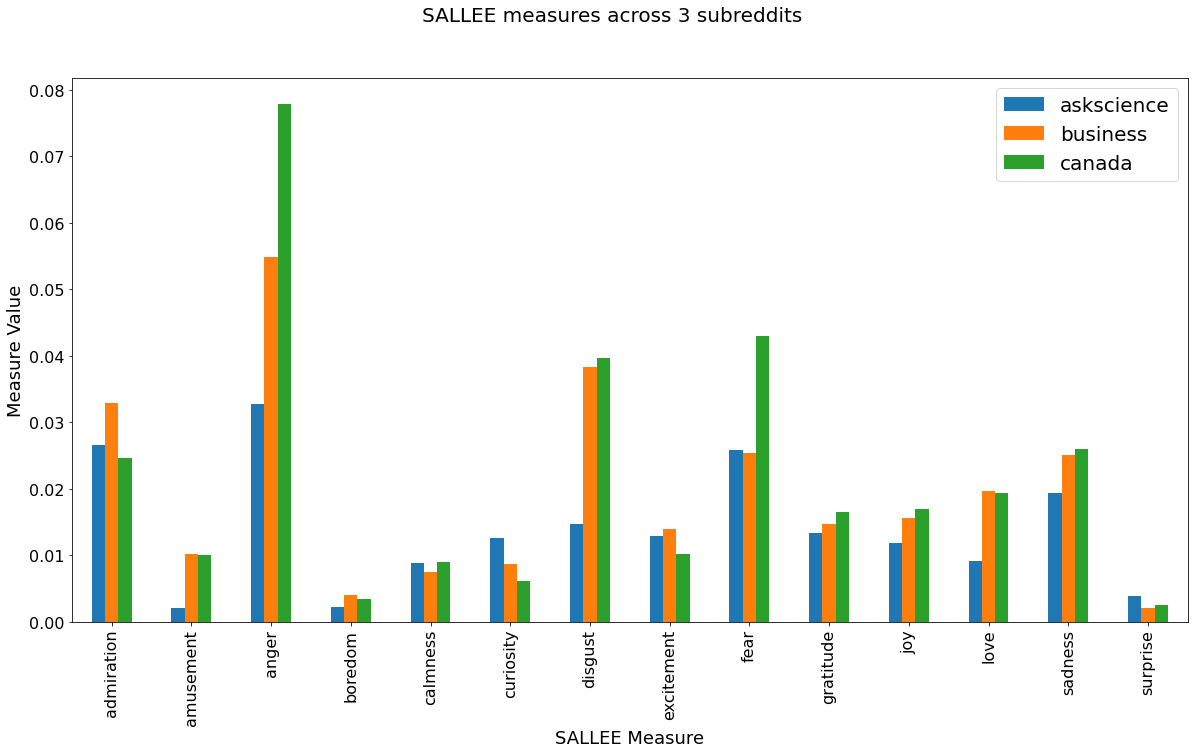

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
g = grouped.plot.bar(ax=ax, rot=90, fontsize=16)
fig.suptitle('SALLEE measures across 3 subreddits', fontsize=20)
_ = plt.xlabel('SALLEE Measure', fontsize=18)
_ = plt.ylabel('Measure Value', fontsize=18)
_ = plt.legend(prop={'size': 20})

- [`r/askscience`](https://www.reddit.com/r/askscience/) is a forum to answer science questions and promote science literacy. 
- [`r/business`](https://www.reddit.com/r/business/) typically contains article posts about companies and business news.
- [`r/canada`](https://www.reddit.com/r/canada/) is a subreddit about Canada containing both political and non-political content about the country at a national scale. 

With that introduction, in the graph above, we see the following:

- Anger is lowest in `r/askscience` and highest in `r/canada` 
- whereas Curiosity follows the opposite trend - highest in `r/askscience` and lowest in `r/canada`
- Fear is highest in `r/canada` since it covers political content